# Анализ ЭЭГ

При регрессии выводить всегда график переменных и того, что на тех же данных показывает нейронка.

Модели с меньшим смещением на имеющихся данных имеют более высокий разброс на новых данных, и наоборот.

Смещение - способность модели аппроксимировать данные обучающей выборки. В результате большого смещения возникает недообучение.

Разброс (дисперсия) алгоритма - ошибка чувствительности к малым отклонениям на обучающей выборке. Характеризует разнообразие моделей, получаемых с помощью алгоритма машинного обучения из-за подбора весов и того факта, что набор данных представляет собой случайную выборку из генеральной совокупности При высокой дисперсии наблюдается переобучение.

SVM бинарный классификатор, выходим из этой ситуации строя лесенку.

Хайкин. Нейронные сети полный курс


In [1]:
#Загружаем датасет через moabb 
import moabb.datasets
import numpy as np
sampling_rate = 512

m_dataset = moabb.datasets.bi2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)

#PPS можно пойти заварить чай и кофе, а так же прогуляться.
# У меня качал датасет 43 минуты. И потребуется примерно 6 гигов свободной памяти. 

m_dataset.download()
m_data = m_dataset.get_data()

KeyboardInterrupt: 

Красным отмечены те каналы, которые записаны в датасете
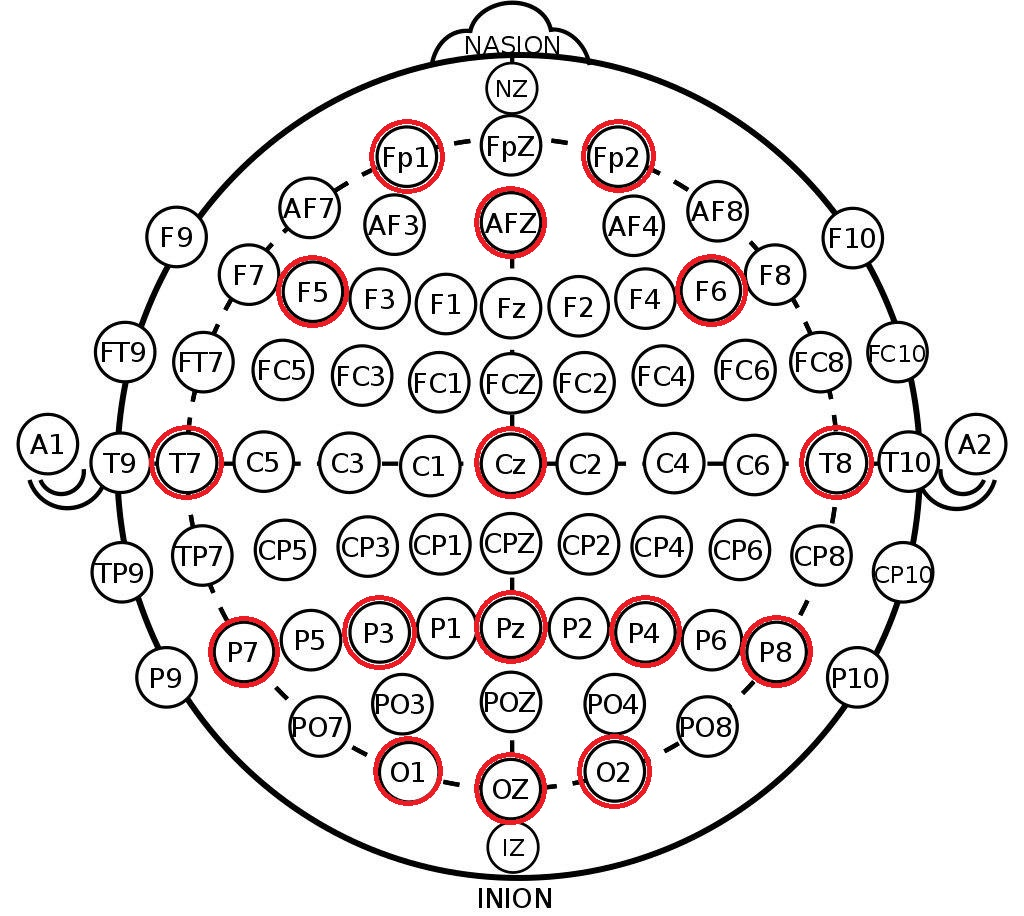

Структура такая: Индекс человека (с 1 до 24-ех)

В них вложены сессии для каждого человека. для 1-7 8 сессий, для 8-24 одна

В каждой сессии 4 запуска. 

В каждом запуске 17 каналов. 16 из которых это датчики, а 17-ый это метки (так и не понял, какие) 

В каждом канале уже идёт показания каждого из датчиков, а в последнем канале идут метки


In [13]:
#Можно заметить, что без .get_data там спрятано что-то по типу генератора.
print(m_data[1]['session_1']['run_1'])

channels = m_data[1]['session_1']['run_1'].ch_names[:]
print(channels)
np.unique(m_data[1]['session_1']['run_1'].get_data()[-1,:])
print(m_data[1]['session_1']['run_1'].get_data()[0].shape)
#Видно, что все запуски отсортированы, а значит лишняя сортировка не нужна

# Структура такая: Индекс человека (с 1 до 24-ех)
# В них вложены сессии для каждого человека. для 1-7 8 сессий, для 8-24 одна
# В каждой сессии 4 запуска. 
# В каждом запуске 17 каналов. 16 из которых это датчики, а 17-ый это метки (так и не понял, какие) 
# В каждом канале уже идёт показания каждого из датчиков, а в последнем канале идут метки


#Тут структура такая: в каждом запуске (которых 4) содержится [0]<- 16 каналов с сигналами [1]<- 1 канал с метками 
# Нельзя засунуть в 1 numpy из-за разной длины сигналов
signal_eeg = np.array([[(p:=run.get_data())[:-1], p[-1]] for run in m_data[1]['session_1'].values()])
signal_eeg[1][0].shape


<RawArray | 17 x 159232 (311.0 s), ~20.7 MB, data loaded>
['Fp1', 'Fp2', 'F5', 'AFz', 'F6', 'T7', 'Cz', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'STI 014']
(159232,)


C:\Users\artbo\AppData\Local\Temp\ipykernel_10436\831769336.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  signal_eeg = np.array([[(p:=run.get_data())[:-1], p[-1]] for run in m_data[1]['session_1'].values()])


(16, 125184)

In [3]:
#raw_dataset = []
print(m_data[1].keys())

# По моему тут написано не очень хорошо
# Если мы не собираемся изменять данные, то list не нужен
# Так же с использованием append каждый раз у нас происходит довыделение памяти
# и объект существует во всех своих промежуточных проявлениях. Это тоже не нужно
# так как мы не делаем никаких промежуточных вычислений
#Так же, пока не посмотрим данные нельзя сказать, нужен ли вообще sorted
#15.5 секунд

# raw_dataset = []
# for _, sessions in sorted(m_data.items()):
#     eegs, markers = [], []
#     for session in sessions:
#         for item, run in sorted(sessions[session].items()):
#             data = run.get_data()
#             eegs.append(data[:-1])
#             markers.append(data[-1])
#         raw_dataset.append((eegs, markers))

#Оптимизировали код
#2.6 секунды

# такую структуру лучше не использовать, пока думаю, на что заменить
raw_dataset = []
for sessions in m_data.values():
    eegs, markers = [], []
    for session in sessions:
        for run in sessions[session].values():
            data = run.get_data()
            eegs.append(data[:-1])
            
            markers.append(data[-1])
    raw_dataset.append((eegs, markers))

# raw_dataset = tuple(   
#                 #eegs                                       # TODO ПОСМОТРЕТЬ НУЖЕН ЛИ SORTED и ITEMS
#                 # tuple(run.get_data()[:-1] for run in sessions[session].values()),
#                 (
#                 (run_data := run.get_data())[:-1],
#                 #markers                                    # TODO ПОСМОТРЕТЬ НУЖЕН ЛИ SORTED и ITEMS
#                 # tuple(run.get_data()[-1] for for run in sessions[session].values()),
#                 run_data[-1]
#                 )               # TODO ПОСМОТРЕТЬ НУЖЕН ЛИ SORTED и ITEMS
#                 # for _, sessions in sorted(m_data.items())
#                 for sessions in m_data.values() for session in sessions.keys() for run in sessions[session].values()
#               )

# raw_dataset = [   
                
#                 [[(run_data := run.get_data())[:-1], run_data[-1]] for run in sessions[session].values()] 
                
#                 for sessions in m_data.values() for session in sessions.keys()
# ]


#raw_dataset = [(*[run.get_data()[:-1] for run in sessions[session].values()], *[run.get_data()[-1] for run in sessions[session].values()]) for sessions in m_data.values() for session in sessions]
print(len(raw_dataset[0][0]))

dict_keys(['session_1', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6', 'session_7', 'session_8'])
32


In [22]:
#Просто проверка на скорость и на количество элементов в каждом из массивов
raw_dataset = []

for _, sessions in sorted(m_data.items()):
    eegs, markers = [], []
    for item, run in sorted(sessions['session_1'].items()):
        data = run.get_data()
        eegs.append(data[:-1])
        markers.append(data[-1])
    print(len(markers[0]))
    raw_dataset.append((eegs, markers))
print(len(raw_dataset))

159232
149088
149504
143008
138944
137888
135744
143968
163136
139328
137600
139584
128000
142720
138976
131424
138688
131840
137248
139680
144064
139424
142848
135040
24


# ДИНАРА, ТЕБЯ ИНТЕРЕСУЕТ ТО, ЧТО НИЖЕ

In [14]:
from scipy import signal
class My_Filter:
    def __init__(self, decimation_factor:int, sampling_rate: int):

        self.dec_fact = decimation_factor
        self.sampling_rate = sampling_rate // self.dec_fact

    def add_butter_param(self, order_filter: int, highpass: int, lowpass: int):
        self.order_filter = order_filter
        self.highpass = highpass
        self.lowpass = lowpass

    def _decim_signal(self):
        #Децимация - то есть понижение частоты дискретизации, то есть увеличиваем расстояние между 2-мя последовательными точками сигнала 
        self.signal = np.array([signal.decimate(self.signal[i], self.dec_fact) for i in range(self.signal.shape[0])])

    def _butter_filter(self):
        Wn = [
            self.highpass * 2 / self.sampling_rate,
            self.lowpass * 2 / self.sampling_rate
            ]
        # b - Вектор коэффициентов числителя фильтра.
        # a - Вектор коэффициентов знаменателя фильтра. Если a[0] не равно 1, то и a, и b нормализуются
        b, a = signal.butter(self.order_filter, Wn, btype='bandpass')
        self.signal = signal.filtfilt(b=b, a=a, x=self.signal)
        return self.signal
    
    def _scaling(self):
        #Сортируем чтоб посчитать медианки
        sort_zn_for_intercvart = np.array([np.sort(self.signal[:,i]) for i in range(self.signal.shape[1])])
        
        #Находим среднее по столбцу (читай среднее по датчику)
        mean = np.median(self.signal, axis=0)
        sh = self.signal.shape[0]
        # Находим интерквартильный размах по 
        # столбцу (читай среднее по датчику)
        intercvarts = np.median(sort_zn_for_intercvart[:,sh//2 + 1 if sh%2 else sh//2 :], axis=1) - np.median(sort_zn_for_intercvart[:, : sh//2 -1], axis=1)

        self.signal = (self.signal - mean) / intercvarts

    def make_filter(self, signal:np.ndarray):
        self.signal = signal
        self._decim_signal()
        self._butter_filter()
        self._scaling()
        return self.signal


    def transform_mark(self, markers):
        modify = {33285.: 1, 33286.: 0}
        return np.array([[index//self.dec_fact, modify[label]] for index, label in enumerate(markers) if label!=0])

decimation_factor = 10
a = My_Filter(decimation_factor=decimation_factor, sampling_rate=512)
a.add_butter_param(4, 0.5, 20)


# Структура m_data такая: Индекс человека (с 1 до 24-ех)
# В них вложены сессии для каждого человека. для 1-7 8 сессий, для 8-24 одна
# В каждой сессии 4 запуска. 
# В каждом запуске 17 каналов. 16 из которых это датчики, а 17-ый это метки (так и не понял, какие) 
# В каждом канале уже идёт показания каждого из датчиков, а в последнем канале идут метки


#Тут структура такая: в каждом запуске (которых 4) содержится [0]<- 16 каналов с сигналами [1]<- 1 канал с метками 
# Нельзя засунуть в 1 numpy из-за разной длины сигналов
signal_eeg = np.array([[(p:=run.get_data())[:-1], p[-1]] for run in m_data[1]['session_1'].values()], dtype=object)
signal_eeg[1][0].shape




#ДАЛЕЕ ИДЁТ КОД ТОЛЬКО ДЛЯ 1 ЧЕЛОВЕКА И 1 СЕССИИ ПОД СТРУКТУРУ ДАННЫХ ВЫШЕ
# Для 1 человека, для одной сессии =================================================================
signs_marks = [
        [
            a.make_filter(eeg_sig), #Отфильтрованный сигнал
            a.transform_mark(marks) #Отфильтрованная маркировка
        ] 
        for eeg_sig, marks in signal_eeg
]


# Выборка только мест после которых либо нет активации, либо она есть, с длительностью 900мс
solo_sign_duration = int(sampling_rate // decimation_factor * 0.9) #45
print(solo_sign_duration)

# for sign, marks in signs_marks:
#     our_sign = np.array([sign[:, start : start+solo_sign_duration] for start in marks[:,0]]),
#     our_labels = marks[: , 1].T
#     print(our_sign[0][1].shape)

cut_sign_label = np.array([
            [
                np.array([sign[:, start : start+solo_sign_duration] for start in marks[:,0]]), #our_sign
                marks[:, 1].T #our_labels
            ]  
            for sign, marks in signs_marks], dtype=object)
# Для 1 человека, для одной сессии ==============================================================================


45


In [15]:
#fig, axs = plt.subplots(nrows= 40 , ncols= 3, figsize=(50, 300))
cut_sign_label[0][0].shape


(480, 16, 45)

In [16]:
import random
a = np.array([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]])
random.SystemRandom().sample(list(a), 2)

[array([1, 2, 3, 4, 5]), array([1, 2, 3, 4, 5])]

In [8]:
import random
import matplotlib.pyplot as plt
def vizual_sign_for_session(sign:np.ndarray):
    fig, axs = plt.subplots(nrows= 64 , ncols= 2, figsize=(50, 300))
    col = {1:"r", 0:"b"}
    count=0
    x = np.arange(0, 900, 20)
    for run in range(4):
        for rand_step in random.SystemRandom().sample(list(np.arange(sign[run][0].shape[0])), 2):
            for y in range(16):
                axs[count//2, count%2].plot(x, sign[run][0][rand_step][y], label=str(y), color=col[sign[run][1][rand_step]])
                axs[count//2, count%2].legend()
                count+=1


vizual_sign_for_session(sign=cut_sign_label)
                
                    

NameError: name 'cut_sign_label' is not defined

Здесь b - это вектор чисел

F = sign( sum( w_i * x_i - b_i)  ) для всех i в размерности векторов

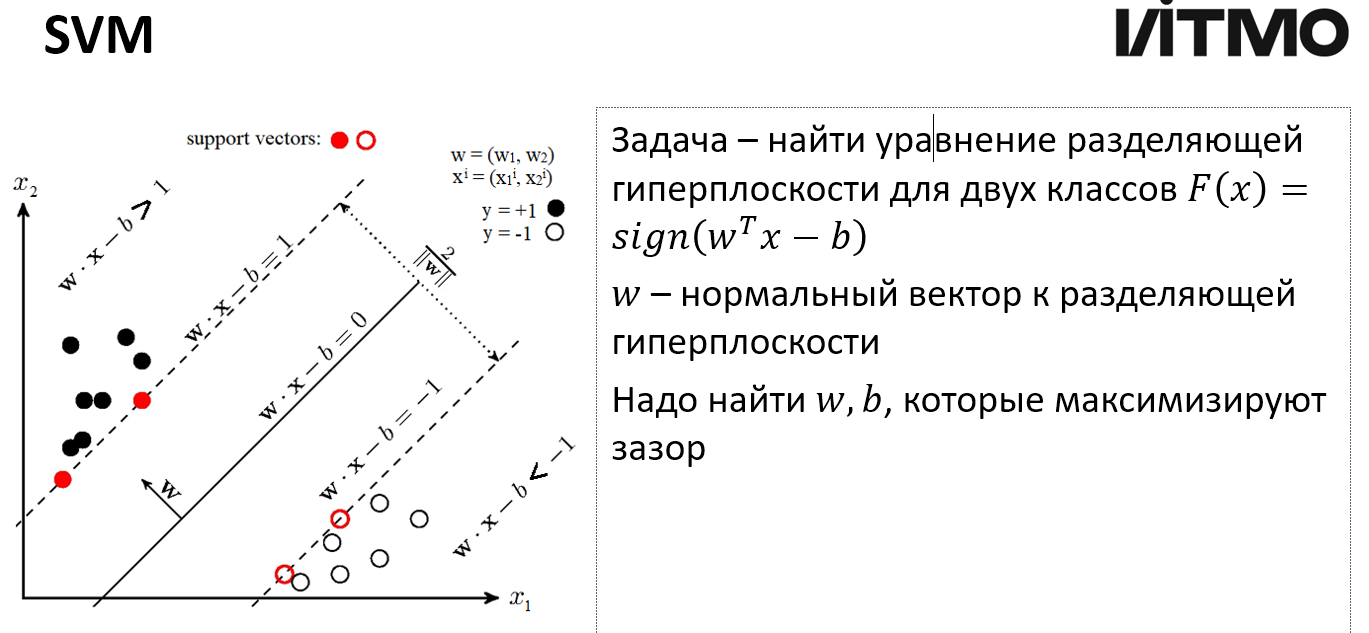

Здесь $ \text{sign} $ это знак $\boldsymbol{x} \cdot \boldsymbol{w} + b. $

$ \text{class}(\boldsymbol{x}) = \text{sign}\left(\boldsymbol{x} \cdot \boldsymbol{w} + b\right). $

а "x" соответственно - координаты какой-то точки

Можно создать матрицу, в которой мы храним произведение y1*y2*ядро
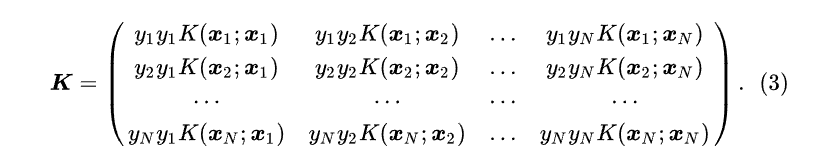

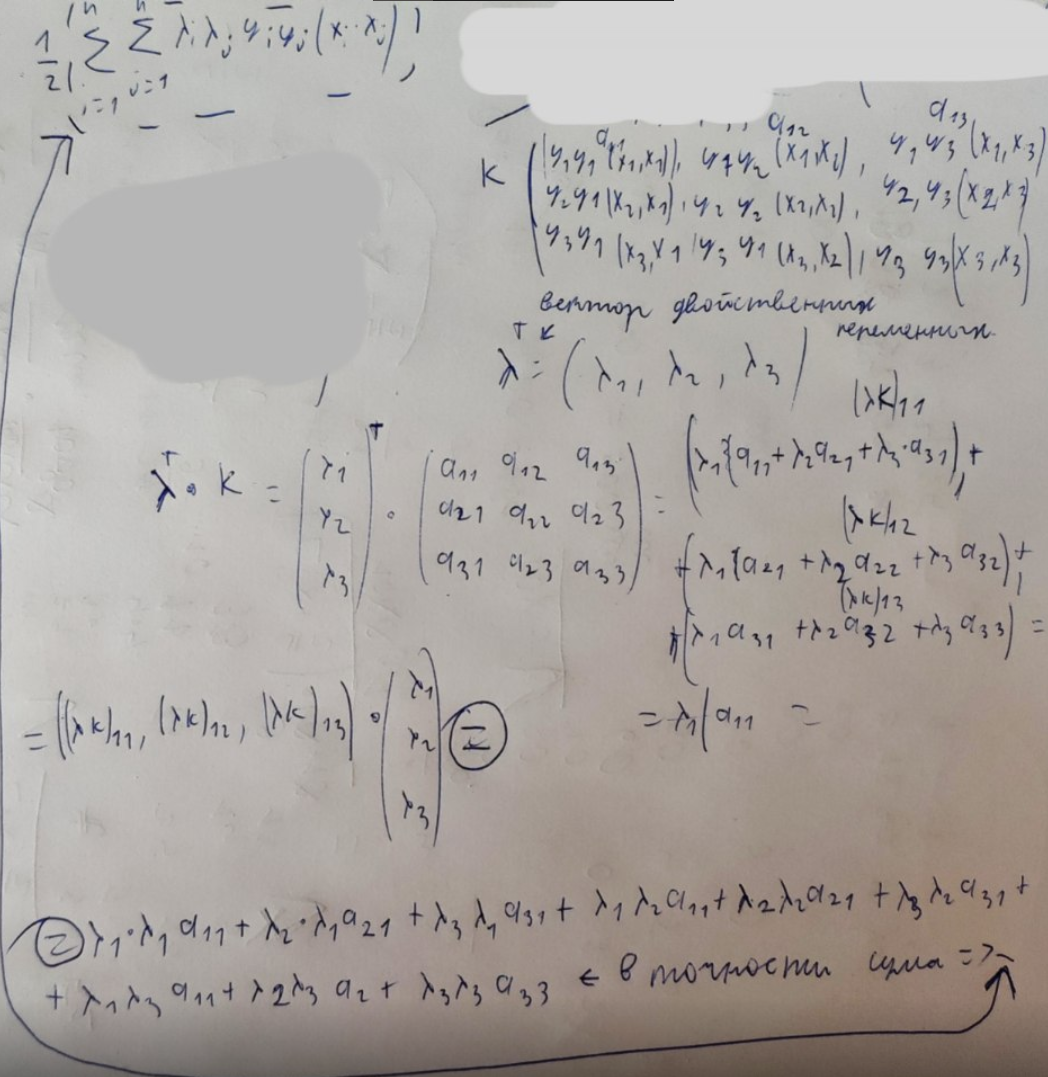

(Далее идёт материал, основа для которого была взята отсюда https://habr.com/ru/post/544282/)

Здесь можно увидеть то, почему формулу выше можно переписать вот таким образом

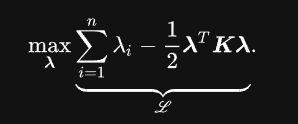

Если расписать l так, чтобы выделить только элементы, которые зависят от  $ \lambda_M,  \lambda_L $ то получим вот такое уравнение

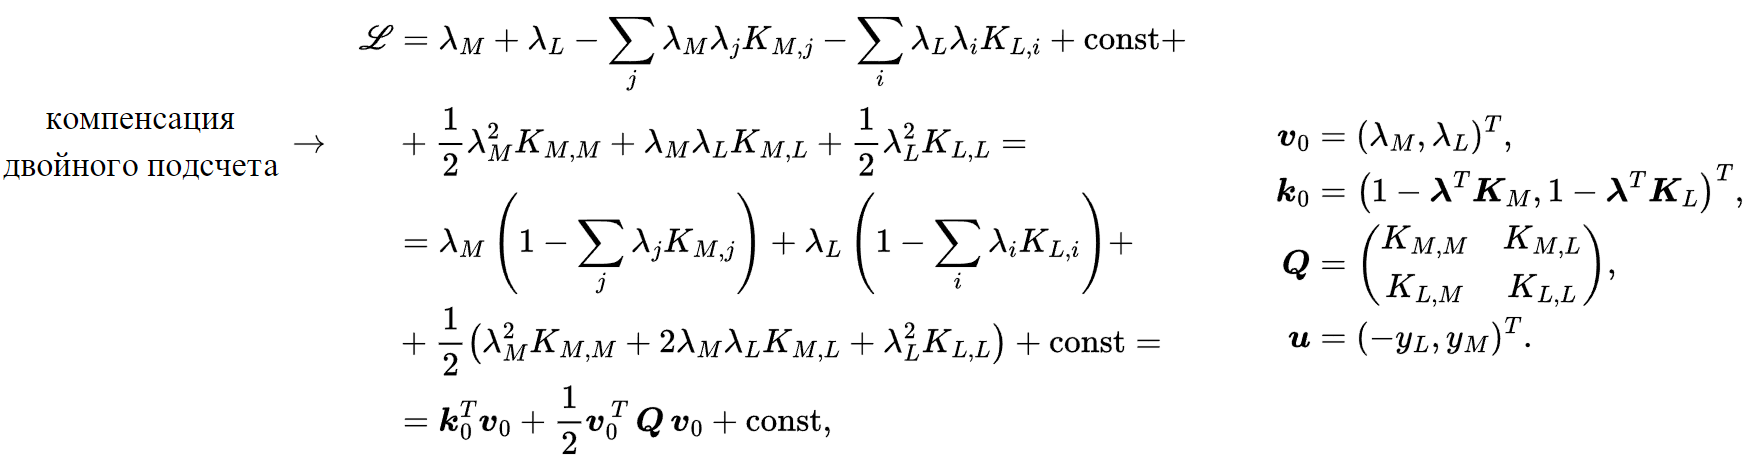

Здесь критически непонятно, почему мы отдельно не считаем $\frac{1}{2} * \lambda_M * \lambda_L * K_{M,L} $ и $\frac{1}{2} * \lambda_L * \lambda_M * K_{L,M} $ а записываем это как $ \lambda_M * \lambda_L * K_{M,L} $ Понятно со множителями, но непонятно с ядром K.

В тексте было написано, что ядно симметрично => нужно спросить преподавателя на лекции из-за чего

Далее, если расписать k0 через Q и v0 то получим следующее:
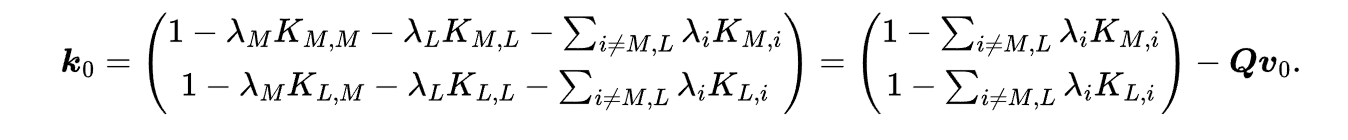

Магия, но если прибавить к k0 Q*v0 то получившаяся у нас сумма не будет зависеть от $ \lambda_M , \lambda_L $

Как было сказанно - ядро - симметрично. То есть $ Q^T = Q$

Тогда перепишем уравнение l уже в матричном виде чуточку иначе

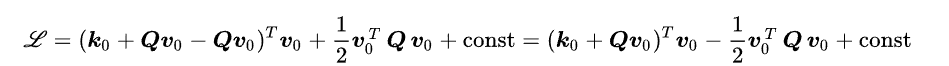

Где const - это все те слагаемые, которые есть в сумме, но которые НЕ зависит от  $ \lambda_M , \lambda_L $

Ещё раз. Внеся в скобку Q*v0 и отняв её позже ($v_{0}$ превращается в $v_{0}^T$ и переносится перед Q. Так как Q - ядро, а ядро - симметрично, то после транспонирования с ним ничего не происходит)

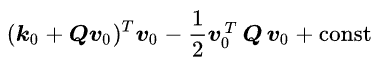

Нам нужн выполнить преобразования так, чтобы выполнялось следующее условие:
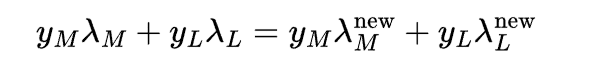

Для этого новая пара значений должна лежать на прямой  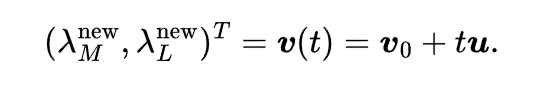

Почему именно такой прямой? Если мы представим, что $ \lambda_M = 2 , \lambda_L = 1 $ и построим прямую, которая гарантирует постоянство их суммы, то получится следующее:

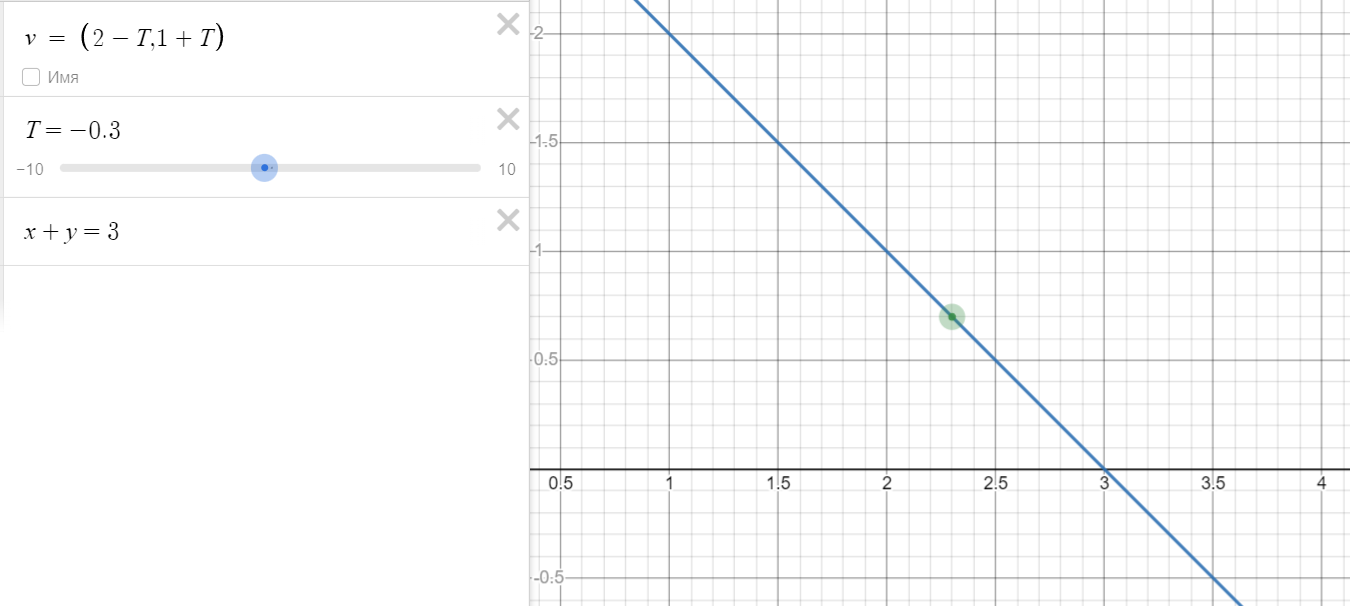

Как можно заметить, если изменить t то точка останется на этой же прямой

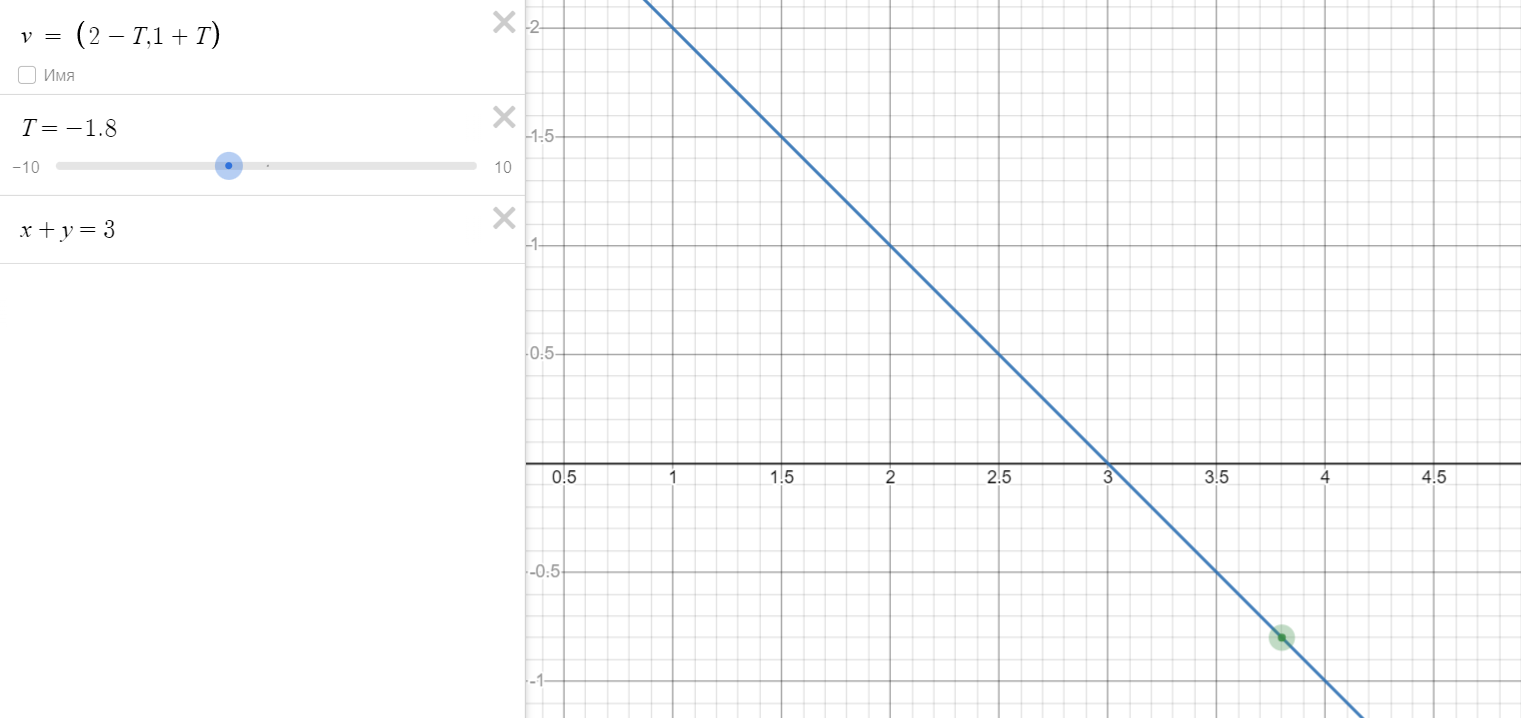

Отсюда выходит, что мы должны максимизировать следующее:

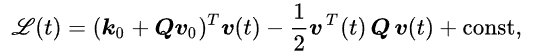

В скобках остался v0 так как если изменится v0, то изменится и k0 и их сумма всё ещё не будет зависеть от $ \lambda_M, \lambda_L $  

Возьмём производную от этого выражения:

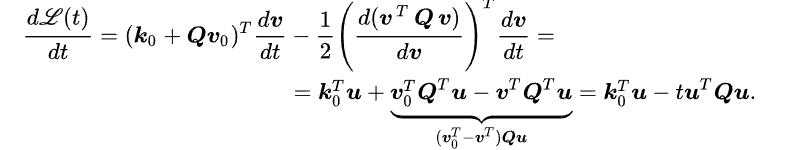

Приравняе производную к нулю и выразим T

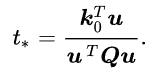

Так же внимательно смотрим, чтобы значения $ \lambda_M, \lambda_L $ находились в пределах C В случаях если они больше него, ставим значение равным C

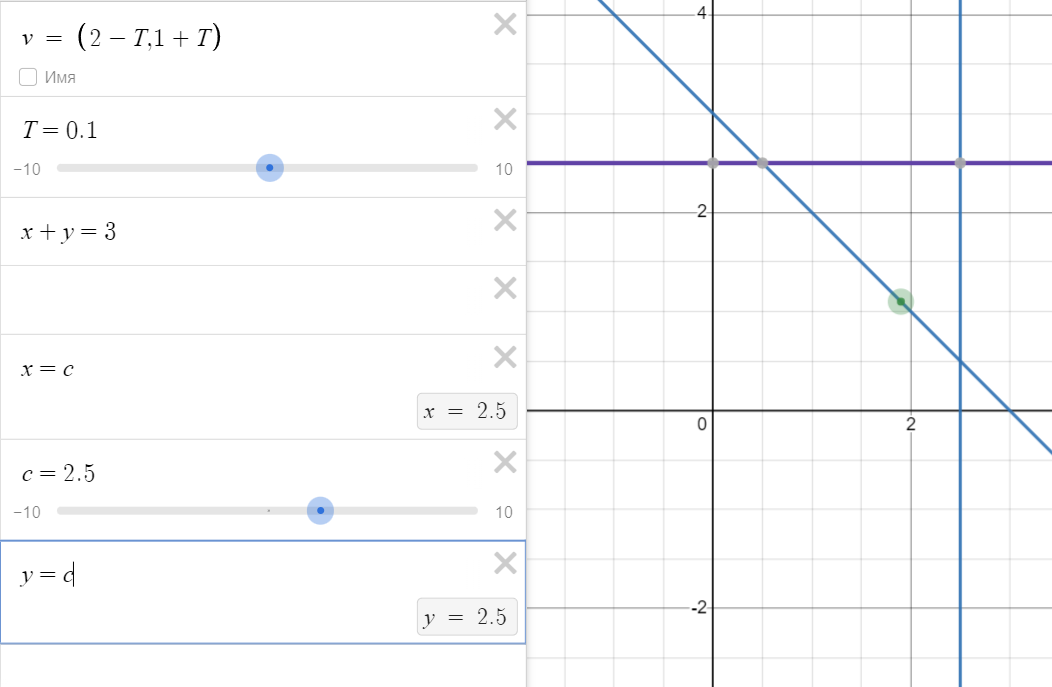

Получается, что:

$  \boldsymbol{k}_0 = \left(1 - \boldsymbol{\lambda}^T\boldsymbol{K}_{M}, 1 - \boldsymbol{\lambda}^T\boldsymbol{K}_{L}\right)^T $

$   \boldsymbol{Q} = \begin{pmatrix} K_{M,M} & K_{M,L} \\ K_{L,M} & K_{L,L} \end{pmatrix}$

$  \boldsymbol{v}_0 = (\lambda_M, \lambda_L)^T $ 

$  \boldsymbol{u} = (-y_L, y_M)^T $ 

$ (\lambda_M^\text{new}, \lambda_L^\text{new})^T = \boldsymbol{v}_0 + t \boldsymbol{u} = \boldsymbol{v}_0 + \frac{\boldsymbol{k}^T_0\boldsymbol{u}}{\boldsymbol{u}^TQ\boldsymbol{u}}\boldsymbol{u}$ 

In [79]:
"""
np.newaxis очень прикольная штука. Она расширяет массив на ещё одну размерность в ТОМ месте, куда её вставить.

Например, у нас есть замечательный массив 
>>> a = np.array([[1,2,3],[2,4,6],[3,6,9]])
>>> b = np.array([[1,1,1], [2,2,2]])
>>> print(a[:, np.newaxis].shape)
    (3, 1, 3)
>>> print(a[np.newaxis, :].shape)
    (1, 3, 3)

Так что же происходит, если мы попытаемя сделать что-то такое: a * a[:, np.newaxis] ?

При умножении a на b[:, np.newaxis], Numpy будет выполнять "broadcasting" для соответствия форм. 
Форма a - (3, 3), а форма b[:, np.newaxis] - (2, 1, 3). Numpy расширит форму a[:, np.newaxis], 
чтобы она соответствовала форме a, путем создания двух "копий" b[:, np.newaxis] вдоль первой оси, 
чтобы соответствовать форме a и выполнить поэлементное умножение.

b[:, np.newaxis] = [[[1, 1, 1],
                     [1, 1, 1],
                     [1, 1, 1]],

                    [[2, 2, 2],
                     [2, 2, 2],
                     [2, 2, 2]]]


То есть, если упростить, то мы поэлементно умножаем каждый элемент массива b ([1,1,1] или [2,2,2]) 
на каждый элемент массива a ([1,2,3],[2,4,6],[3,6,9]), и результат записываем в последнем измерении b, то есть:

[ [a[0] * b[0],         
   a[1] * b[0],
   a[2] * b[0]],

  [a[0] * b[1],
   a[1] * b[1],
   a[2] * b[1]] ]

   
где a[0] == [1,2,3], a[1] == [2,4,6], a[2] == [3,6,9]
    b[0] == [1,1,1], b[1] == [2,2,2]


В итоге получим:
[ [[ 1  2  3]
   [ 2  4  6]
   [ 3  6  9]]

  [[ 2  4  6]
   [ 4  8 12]
   [ 6 12 18]] ]
"""


#СУММА ЛЯМБД УМНОЖЕННЫХ НА Y НЕ РАВНА НУЛЮ ЛЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯЯ
import numpy as np
class My_SVM:
    def __init__(self, kernel:str="linear", C:float=10, poly_deg:float = 2, rad_gamma:float=13, sigm_gamma:float = 13, sigm_betta:float = 0, max_iter:int = 4300):
        #Сразу при инициализации выбирается ядро, и его функция записывается в self.kernel
        self.kernel_transform = {
            "linear": lambda x_i, x_j: np.dot(x_i, x_j.T),
            "poly":lambda x_i, x_j: (1 + np.dot(x_i, x_j.T))**poly_deg,    #Cмотри гайд на np.newaxis
            "rad_func": lambda x_i, x_j: np.exp(-rad_gamma*np.sum((x_i - x_j[:, np.newaxis])**2, axis=-1)),
            "sigm": lambda x_i, x_j: np.tanh(sigm_gamma*np.dot(x_i, x_j.T) + sigm_betta)
            }[kernel]
        
        self.C = C
        self.max_iter = max_iter

    def check_max_c(self, v, t, u):
        #Здесь отсекаем выход за пределы для нулевого  индекса
        t_zer_cheked = (np.clip(a = v+t*u, a_min = 0, a_max = self.C) - v)[0] / u[0]
        # здесь отсекаем выход за пределы для первого индекса
        return (np.clip(a = v+t_zer_cheked*u, a_min = 0, a_max = self.C) - v)[1] / u[1]
    

    def fit(self, X:np.ndarray, y:np.ndarray):
        #Магическая (не совсем) штука, которая делает deepcopy без использования deepcopy
        #Тут прикол в том, что умножение создаёт новую ссылку на объект, если для него не указано другое.
        #Сответственно, так как это не листы, то мы переписываем ссылки для всех объектов вглубь,
        #По сути делая тот же самый deepcopy только средствами numpy
        self.X = X * 1
                #переводим в формат -1, 1 для простоты вычислений.
        self.y = y*2 - 1
        self.lambdas = np.zeros_like(self.y, dtype=np.float32)
                    #Cмотри гайд на np.newaxis
        # print("1", self.kernel_transform(self.X, self.X).shape)
        # print("2", (self.kernel_transform(self.X, self.X) * y[:, np.newaxis]). shape)
        self.K = self.kernel_transform(self.X, self.X) * self.y[:, np.newaxis] * self.y
        # print(self.K)
        # print(self.y)
        #пока просто по итерациям пройдёмся, потом тут будет стоять цикл while с условием 
        for _ in range(self.max_iter):
            for ind_M in range(self.lambdas.shape[0]):
                zn_flag = self.y[ind_M]

                #пока выбирается рандомно, переделать на более интересный выбор
                ind_L = np.random.randint(0, self.lambdas.shape[0])  
                # ind_L = np.random.choice(np.where(self.y == zn_flag*-1)[0]) 

                Q = self.K[
                    [[ind_M, ind_M], [ind_M, ind_L]], 
                    [[ind_L, ind_M], [ind_L, ind_L]]
                    ]
                
                k_0 = 1 - np.dot(self.K[[ind_M, ind_L]], self.lambdas)
                v_0 = self.lambdas[[ind_M, ind_L]]
                u = self.y[[ind_M, ind_L]]   * [-1, 1]
                # u = u[0] * -1
                                    #Проверить
                # print((np.dot(np.dot(u, Q), u)))
                t = (np.dot(k_0.T, u)) / (np.dot(np.dot(u, Q), u) + 1E-15)
                
                self.lambdas[[ind_M, ind_L]] = v_0 + u * self.check_max_c(t=t, v=v_0, u=u)

        self.op_vectors = np.nonzero((self.C >self.lambdas) * (self.lambdas > 1E-13))[0]
        print(np.sum(self.lambdas*self.y))
        print(self.op_vectors)
        #Проверить правильность формул. UNDone       было без кернела
        # self.w =np.dot(self.lambdas * self.y, self.kernel_transform(self.X, self.X))
        self.w = self.lambdas * self.y
        self.w = np.dot(self.lambdas * self.y, self.kernel_transform(self.X, self.X))
        print(self.w)

        #ПРОБЛЕМЫ С ВЫЧИСЛЕНИЕМ B ПРИ ДОБАВЛЕНИИ ЯДРА!!!!!!!!!------------------------------------------------------------------------
        self.b = np.median(np.dot(self.lambdas*self.y, self.K[self.op_vectors].T) - self.y[self.op_vectors])
        # self.b = np.mean(np.dot(self.w, self.kernel_transform(self.X[self.op_vectors], self.X).T) - self.y[self.op_vectors])
        # self.b = np.min(np.dot(self.w, self.K[self.op_vectors].T) - self.y[self.op_vectors])
        # self.b = np.mean(np.dot(self.w, self.X[self.op_vectors].T) - self.y[self.op_vectors])
        #self.b = np.mean(self.w * self.X[self.op_vectors] - self.y[self.op_vectors])
        # self.b = np.dot(self.w, self.X.T) - self.y
        #self.b = np.mean(self.kernel_transform(self.X, self.X) * self.w - self.y, axis=1)
        # print(self.w)
        print(self.b)
    
    def decision(self, X):
        return np.dot(self.w, self.kernel_transform(X, self.X).T) - self.b
    def predict(self, X):
                                # sign( sum( w_i * x_i - b_i)  ) для всех i в размерности векторов
                                # Нужно проверить не накосячил ли я 
        return np.sign(self.decision(X))


In [2]:
import numpy as np
# a = np.array([[1,2,3],[2,4,6],[3,6,9]])
# b = np.array([[1,1,1], [2,2,2]])
# print(a[:, np.newaxis].shape)
# print(a[np.newaxis, :].shape)
# print(a[:, :, np.newaxis].shape)
# a * a[:,np.newaxis]

# print(a[:, np.newaxis][0])
# print()
# print(b[:,np.newaxis] * a)

# print(a* b[:, np.newaxis])
# a = np.array([1,2,3,4,5,6])
# print(a.shape)

# a = [[[1,2,3,4], [1,3,3,5], [2,2,1,3]], [1,1,0]]
# print(list(zip(*a))
# np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1))

lambdas = np.array([1,3,2,1])
c = 1
d = 3
b = np.array([1,2,3,4])
x = np.array([[1,2,3,4],
              [8,3,7,14],
              [1,4,4,15],
              [3,1,15,5]])

x = np.array([[1,2],
              [2,3],
              [3,4],
              [5,6],
              [7,8]])

y = np.array([[1,2],
              [2,3],
              [3,4]])
(np.dot(x, x.T) + c)**d
# print(lambdas * x - b)
# s = np.array([1,3,4,2])
# y = np.array([1,-1,-1,1])
# lambdas = np.array([0.4,0.6,0.4,0.6])

# print((lambdas*y)[:, np.newaxis])
# print((lambdas * y)[:, np.newaxis]*x)
# print(np.sum((lambdas * y)[:, np.newaxis]*x, axis=0))

# print(np.dot(lambdas * y, x))
# print(x+s)
# print((np.dot(y, (x+s).T)))

array([[    216,     729,    1728,    5832,   13824],
       [    729,    2744,    6859,   24389,   59319],
       [   1728,    6859,   17576,   64000,  157464],
       [   5832,   24389,   64000,  238328,  592704],
       [  13824,   59319,  157464,  592704, 1481544]], dtype=int32)

In [11]:
u = np.array([3,9])
Q = np.array([[1, 2], 
              [3, 4]])
np.dot(np.dot(u, Q), u)
lambdas = np.array([-1, 4])
K = np.array([[1,2],
     [4,5]])
print(np.sum(K, axis=0))
print(1 - np.dot(K[[0, 1]], lambdas))
1 - np.sum(lambdas * K[[0, 1]], axis=1)   

[5 7]
[ -6 -15]


array([ -6, -15])

(100, 2) (100,)
-0.39959515631198883
[15 18 20 23 37 45 57 59 98]
[-2.02035848 -1.89679001 -2.12466369 -1.90372457 -2.08135186 -1.684542
 -2.07448407 -1.90530628 -1.99128098 -1.86634777 -1.906888   -1.85124747
 -1.96306945 -2.41030055 -2.22613052 -1.99397029 -2.10808974 -1.97999309
 -1.61208589 -1.97934412 -1.58987618 -1.90389941 -2.60855583 -1.51144289
 -1.53358667 -1.65910208 -1.71868858 -1.88855748 -1.9593651  -1.80700289
 -1.74600951 -1.72091928 -2.13939878 -2.16225747 -1.82598239 -2.15280845
 -2.02258918 -2.1476313  -2.13224724 -1.87939223 -2.11179409 -1.82041257
 -2.20240587 -1.67303714 -1.515431   -1.88233868 -1.91382256 -2.04469082
 -1.93280206 -1.9761139   2.55590003  2.22900718  2.81720454  1.70132908
  2.50112545  2.10719528  2.42015306  0.64846072  2.41122943  1.41774808
  1.02646592  1.85193472  1.74488254  2.42791145  1.09321949  2.19557636
  2.09185335  1.62354477  2.52797225  1.4704668   2.53819384  1.68141684
  2.87219609  2.38226     2.0417405   2.20474162  2.75027611

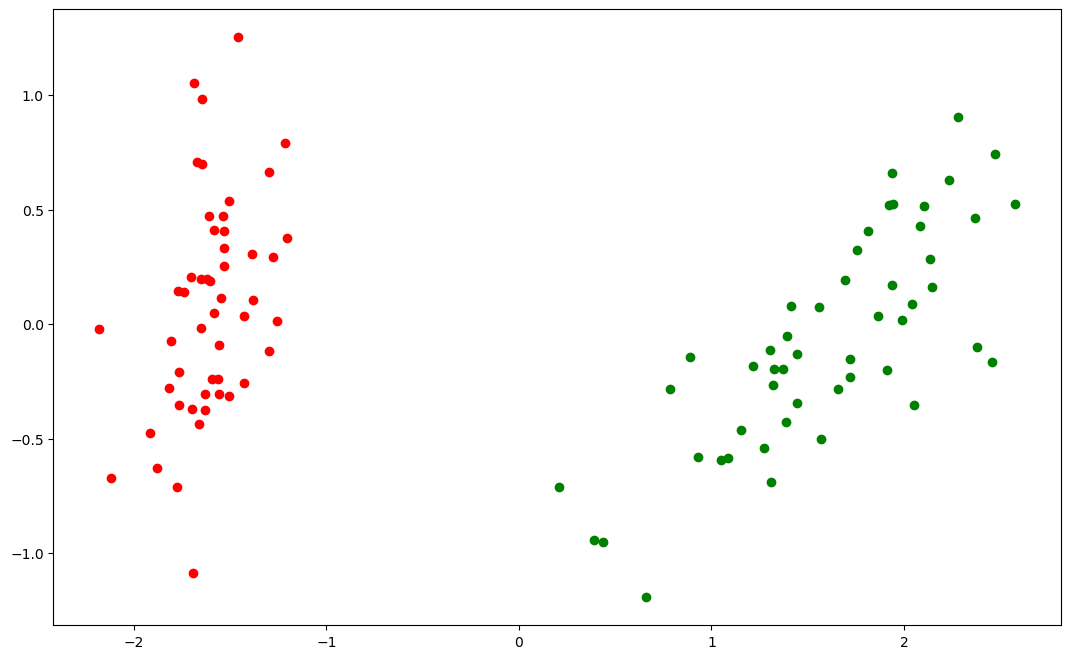

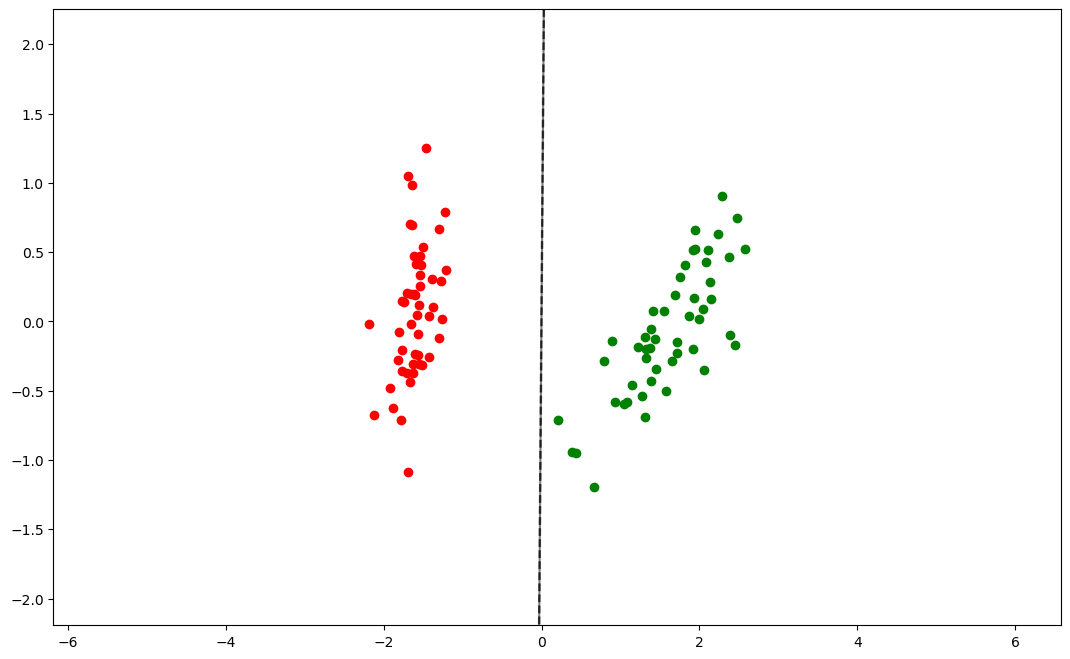

In [81]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
iris = load_iris()

X = iris.data
Y = iris.target

X = X[Y!=2]
X = pca.fit_transform(X)
Y = Y[Y!=2]

print(X.shape, Y.shape)

def show_data(X, Y, model=None, flag = False):
    plt.figure(figsize=(13, 8))
    colors = ["red", "green", "blue", "black", "yellow", "gray", "pinck"]
    keys = np.unique(Y)
    for i, key in enumerate(keys):
        plt.scatter(X[Y==key][:,0], X[Y==key][:,1], c=colors[i])
    
    if flag:
        xlim = [np.min(X[:, 0])-4, np.max(X[:, 0])+4]
        ylim = [np.min(X[:, 1])-1, np.max(X[:, 1])+1]
        xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
        z_model = model.decision(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.show()

svm = My_SVM(kernel="linear", poly_deg=3)
svm.fit(X = X, y=Y)

otvs = svm.predict(X=X)

show_data(X, Y)
show_data(X, otvs, model=svm, flag=True)